## Load data and libraries

In [38]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF
from pyspark.sql.functions import regexp_replace, lower
import os
from pyspark.ml.feature import HashingTF
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Set up session
spark = SparkSession.builder.appName('nlp').getOrCreate()

# Read data from the csv file
pandas_df = pd.read_csv('spark_data.csv')
pandas_df['review_text'] = pandas_df['review_text'].astype(str)
df = spark.createDataFrame(pandas_df)
df.show()

C:\Users\herre\Desktop\spark\spark\spark-3.3.2-bin-hadoop2\python\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Users\herre\Desktop\spark\spark\spark-3.3.2-bin-hadoop2\python\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


+---------+-------+--------------------+-----+
|review_id| app_id|         review_text|label|
+---------+-------+--------------------+-----+
|137272710|1679290|I need to praise ...|    0|
|137272945|1663220|Long as I play to...|    1|
|137274382|1816950|[h1]More interest...|    1|
|137274860|2281730|   mw rip off  💀 \n|    1|
|137274157|2281730|Puede que sea una...|    1|
|137273715|2281730|     cool mw clone\n|    1|
|137273443|2281730|                nice|    1|
|137273157|2281730|Just bad. 3v3 TDM...|    0|
|137272989|2281730|I'll just stick t...|    0|
|137272642|2281730|Quickest way to h...|    1|
|137273689|1860510|This game is very...|    0|
|137273626|2181140|Hope's End is an ...|    1|
|137272328|2181140|Fun tower defense...|    1|
|137274560|1289340|I'm a bit surpris...|    1|
|137274405|2327940|sound is not adju...|    0|
|137274351|2327940|The game mechanic...|    1|
|137273568|2327940|Very good gamepla...|    1|
|137273988|2304990|This game is very...|    0|
|137272937|230

## Preprocessing data
- lowercase
- remove special characters
- fill na values

In [39]:
def preprocess(df, column):
    df = df.withColumn('review_text_cleaned', lower(regexp_replace(column, '[^\\sa-zA-Z0-9]', '')))
    df = df.na.fill('null')
    return df
    
df = preprocess(df, 'review_text')

# train test split
trainData, testData = df.randomSplit([0.7, 0.3], seed=0)

## Perform TF-IDF

In [40]:
def tf_idf(df_train, df_test):

    # Tokenize
    tokenizer = Tokenizer(inputCol='review_text_cleaned', outputCol='words')
    df_tokenized_train = tokenizer.transform(df_train)
    df_tokenized_test = tokenizer.transform(df_test)
    
    # Term frequencies
    cv = CountVectorizer(inputCol='words', outputCol='rawFeatures', vocabSize=1000)
    cv_model = cv.fit(df_tokenized_train)
    featurizedData_train = cv_model.transform(df_tokenized_train)
    featurizedData_test = cv_model.transform(df_tokenized_test)

    # Compute IDF vectors
    idf = IDF(inputCol='rawFeatures', outputCol='features')
    idfModel = idf.fit(featurizedData_train)
    rescaled_train_temp = idfModel.transform(featurizedData_train)
    rescaled_test_temp = idfModel.transform(featurizedData_test)
    
    # Save models
    cv_model_dir = os.path.join(os.getcwd(),'cv_model')
    idf_model_dir = os.path.join(os.getcwd(),'idf_model')
    cv_model.write().overwrite().save(cv_model_dir)
    idfModel.write().overwrite().save(idf_model_dir)
 
    
    return rescaled_train_temp, rescaled_test_temp

In [41]:
rescaled_train, rescaled_test = tf_idf(trainData, testData)

## Train logistic model

In [42]:
lr = LogisticRegression(featuresCol="features", labelCol="label")
lrModel = lr.fit(rescaled_train)
predictions = lrModel.transform(rescaled_test)
predictions.select('probability', 'label', 'prediction').show(truncate=False)

+------------------------------------------+-----+----------+
|probability                               |label|prediction|
+------------------------------------------+-----+----------+
|[1.4102257473662958E-132,1.0]             |1    |1.0       |
|[0.0,1.0]                                 |1    |1.0       |
|[9.52539862304375E-247,1.0]               |0    |1.0       |
|[2.656921500796729E-84,1.0]               |1    |1.0       |
|[3.0412279492517406E-71,1.0]              |1    |1.0       |
|[0.0,1.0]                                 |1    |1.0       |
|[2.141434476000728E-75,1.0]               |1    |1.0       |
|[0.0,1.0]                                 |1    |1.0       |
|[2.0210128756810398E-227,1.0]             |1    |1.0       |
|[0.06249994668265984,0.9375000533173402]  |1    |1.0       |
|[6.765451673985638E-30,1.0]               |1    |1.0       |
|[2.448558409908541E-7,0.9999997551441591] |1    |1.0       |
|[0.0,1.0]                                 |1    |1.0       |
|[5.3698

## Evaluate performance

In [43]:
pandas_df = predictions.select('label','probability','prediction').toPandas()
labels = pandas_df['label']
predicted = pandas_df['prediction']
probabilities = pandas_df['probability'].apply(lambda x: x[1])

AUC:  0.7806461352657004


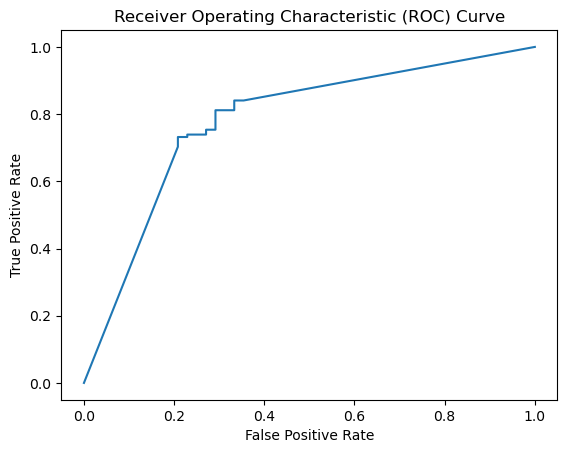

In [47]:
# AUC/ROC
fpr, tpr, thresholds = roc_curve(labels, probabilities)
plt.plot(fpr, tpr)
auc = roc_auc_score(labels, probabilities)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
print('AUC: ', auc)

In [45]:
# Confusion matrix and accuracy
cm = confusion_matrix(labels, predicted)

print(cm)
accuracy = accuracy_score(labels, predicted)
print('accuracy: ', accuracy)
print('accuracy if all predictions are 1: ', np.mean(labels))

[[ 34  14]
 [ 26 112]]
accuracy:  0.7849462365591398
accuracy if all predictions are 1:  0.7419354838709677


## Save logistic regression model

In [46]:
lr_model_dir = os.path.join(os.getcwd(),'lr_model')
lrModel.write().overwrite().save(lr_model_dir)